In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


if False:
    import keras
    from keras import backend as K
    from keras.models import Sequential, Model
    from keras.layers.normalization import BatchNormalization
    from keras.utils.data_utils import get_file
    from keras.models import Sequential
    from keras.layers.core import Flatten, Dense, Dropout, Lambda
    from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
    from keras.layers.pooling import GlobalAveragePooling2D
    from keras.optimizers import SGD, RMSprop, Adam
    from keras.preprocessing import image
    print("Keras {}, TensorFlow {}".format(keras.__version__, keras.backend.tf.__version__))

# Data to train and validation 

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [41]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


**Note we dropped VERBATIM class**

In [8]:
grouped_sentences = all_data.groupby('sentence_id')

In [42]:
validation_indexes_grouped = random.sample(list(grouped_sentences.indices.values()), int(len(grouped_sentences)*0.3))
validation_indexes = [item for sublist in validation_indexes_grouped for item in sublist]

In [43]:
validation_data = all_data.loc[validation_indexes]
train_data = all_data.loc[~all_data.index.isin(validation_indexes)]
train_data = train_data.sort_values(['sentence_id','token_id'])
validation_data = validation_data.sort_values(['sentence_id','token_id'])

In [44]:
print("sizes: all_data {}, train_data {} ({:.4f}), validation_data {} ({:.4f})".format(
    len(all_data), len(train_data), len(train_data)/len(all_data),
    len(validation_data), len(validation_data)/len(all_data)))
print("Match : {}".format(len(all_data)==(len(validation_data)+len(train_data))))

sizes: all_data 9840282, train_data 6887505 (0.6999), validation_data 2952777 (0.3001)
Match : True


In [41]:
train_data.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


In [42]:
validation_data.head()

,sentence_id,token_id,class,before,after
10,1.0,0.0,DATE,2006,two thousand six
11,1.0,1.0,LETTERS,IUCN,i u c n
12,1.0,2.0,PLAIN,Red,Red
13,1.0,3.0,PLAIN,List,List
14,1.0,4.0,PLAIN,of,of


### Getting words

In [ ]:
td = testing_data = validation_data.copy()

In [ ]:
d = testing_data.groupby(['before', 'after']).size()
d = d.reset_index().sort_values(0, ascending=False)
d = d.loc[d['before'].drop_duplicates(keep='first').index]
d = d.loc[d['before'] != d['after']]
d = d.set_index('before')['after'].to_dict()

In [ ]:
all_words = list(set(list(all_data['before']) + list(all_data['after'])))

In [ ]:
len(all_words)

In [ ]:
all_words_indices = dict((c, i) for i, c in enumerate(all_words))

In [ ]:
%%time
train_x = np.zeros(len(all_data['before']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_x[idx] = all_words_indices[word]

In [ ]:
train_y = np.zeros(len(all_data['after']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_y[idx] = all_words_indices[word]

### More balanced sample

In [359]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [377]:
all_data_classes = list(all_data.groupby('class'))

In [389]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
9145012,696045,8,ADDRESS,C2,c two
3902879,302356,3,ADDRESS,SR-263,s r two sixty three
4018111,311149,9,CARDINAL,96,ninety six
9497885,722622,11,CARDINAL,2977,two thousand nine hundred seventy seven


In [512]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [513]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [993]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
7509636,573952,10,PLAIN,the,the
7475877,571397,4,PLAIN,of,of
9801958,745193,13,DATE,1921,nineteen twenty one
5668815,435882,0,DIGIT,08,o eight
518674,41887,1,TELEPHONE,0-520-01660-2,o sil five two o sil o one six six o sil two
3547876,275387,7,DATE,1999,nineteen ninety nine
1588436,125430,3,DIGIT,2948,two nine four eight
7571317,578631,8,PUNCT,.,.
8464662,645479,4,DATE,1948,nineteen forty eight
1620085,127854,3,MONEY,"Rs 1,432 cr",one thousand four hundred thirty two crore rupees


# Predicting string class from characters

In [514]:
categories_all = train_data["class"].unique()
print(categories_all)
len(categories_all)
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'MEASURE' 'ORDINAL' 'DECIMAL'
 'TIME' 'DIGIT' 'MONEY' 'ELECTRONIC' 'TELEPHONE' 'FRACTION' 'ADDRESS']


In [409]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [735]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, letters_n)
    for li, letter in enumerate(line):
        tensor[li][0][letters_index[letter]] = 1
    return tensor
print(lineToTensor('wordup').size())

torch.Size([6, 1, 112])


In [956]:
use_cuda = False

In [959]:
use_cuda = True

In [971]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        #self.gru = nn.GRU(input_size, hidden_size)
        self.lin_1 = nn.Linear(hidden_size, output_size)

    def forward(self, word, hidden):
        all_outputs, hidden = self.gru(word, hidden)
        #output = hidden
        #output = output.view(1, -1)
        output = all_outputs[-1]
        output = self.lin_1(output)
        output = F.log_softmax(output)
        return output

    def initHidden(self):
        var = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        #var = Variable(torch.zeros(1, self.hidden_size))
        if use_cuda:
            var = var.cuda()
        return var


rnn = RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all))
print("Using cuda: {}".format(use_cuda))
if use_cuda:
    rnn = rnn.cuda()

Using cuda: True


In [858]:
lineToTensor('wordup').size()

torch.Size([6, 1, 112])

In [939]:
rnn = nn.GRU(4, 3, num_layers=2, batch_first=True)  # Input dim is 3, output dim is 3
inputs = [Variable(torch.randn((1, 4))) for _ in range(5)]  # make a sequence of length 5
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
#hidden = Variable(torch.randn(2, 1, 3))
arr = [0.0489, -0.3077, -0.0098]
hidden = Variable(torch.from_numpy(np.array([arr, arr])).float()).view(2, 1, -1)
res, hidden = rnn(inputs, hidden)

#rnn(Variable(torch.zeros(4, 1, 112)), Variable(torch.zeros(1, 1, 128)))
rnn(Variable(torch.zeros(4, 1, 112)), rnn.initHidden())

In [860]:
input_info = Variable(lineToTensor('wordup'))
# hidden = Variable(torch.zeros(1, n_hidden))

if use_cuda:
    output = rnn(input_info.cuda(), rnn.initHidden())
else:
    output = rnn(input_info, rnn.initHidden())
print(output)

Variable containing:

Columns 0 to 9 
-2.6633 -2.6343 -2.6845 -2.6679 -2.6163 -2.7538 -2.6775 -2.6830 -2.7373 -2.7680

Columns 10 to 14 
-2.8636 -2.7344 -2.8343 -2.7743 -2.5727
[torch.cuda.FloatTensor of size 1x15 (GPU 0)]



In [58]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(categoryFromOutput(output))

('TELEPHONE', 12)


In [464]:
data = data_balanced_classes.sample(frac=1)
train_x = list(data['before'])
train_y = list(data['class'])

In [794]:
def randomTrainingExample():
    #sample = data_balanced_classes.sample(1)
    #category = sample['class'].item()
    #line = sample['before'].item()
    i = random.randint(0, len(train_x)-1)
    category = train_y[i]
    line = train_x[i]
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    line_tensor = Variable(lineToTensor(line))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        line_tensor = line_tensor.cuda()
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line,
          '     (', category_tensor.size())

category = PUNCT / line = .      ( torch.Size([1])
category = LETTERS / line = Ba'ath      ( torch.Size([1])
category = PLAIN / line = also      ( torch.Size([1])
category = DATE / line = 2012      ( torch.Size([1])
category = PLAIN / line = Lithuanian      ( torch.Size([1])
category = CARDINAL / line = 202      ( torch.Size([1])
category = DATE / line = April 30th, 1918      ( torch.Size([1])
category = PLAIN / line = which      ( torch.Size([1])
category = DATE / line = 2003      ( torch.Size([1])
category = DATE / line = October 6, 2014      ( torch.Size([1])


In [792]:
randomTrainingExample()[2]

Variable containing:
 0
[torch.LongTensor of size 1]

In [453]:
%%timeit
randomTrainingExample()

13.6 µs ± 66.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [730]:
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor, learning_rate=0.001):
    #hidden = rnn.initHidden()

    rnn.zero_grad()
    #for i in range(line_tensor.size()[0]):
    #    output, hidden = rnn(line_tensor[i], hidden)
    output = rnn(line_tensor, rnn.initHidden())

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [184]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [731]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    rrn.train()
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else "✗ ({})".format(category)
            print("{:>6d} {:>4.0%} ({:>8}) {:>6.2f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                line, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
            
    return all_losses

In [853]:
all_losses = train_iterations()

  5000   5% (  0m 23s)   2.00   |   2.10: : -> DATE ✗ (PUNCT)
 10000  10% (  0m 47s)   1.70   |   1.93: 2, -> PLAIN ✗ (CARDINAL)
 15000  15% (  1m 11s)   1.53   |   4.61: 10th -> DATE ✗ (ORDINAL)
 20000  20% (  1m 35s)   1.37   |   1.31: UTA -> LETTERS ✓
 25000  25% (  1m 54s)   1.17   |   1.11: HDP -> LETTERS ✓
 30000  30% (  2m 14s)   1.03   |   2.54: 80,000 -> DATE ✗ (CARDINAL)
 35000  35% (  2m 33s)   0.88   |   4.68: 08 -> CARDINAL ✗ (DIGIT)
 40000  40% (  2m 52s)   0.79   |   0.69: EZH -> LETTERS ✓
 45000  45% (  3m 12s)   0.71   |   1.96: x -> PUNCT ✗ (LETTERS)
 50000  50% (  3m 31s)   0.71   |   0.05: firefighter -> PLAIN ✓
 55000  55% (  3m 50s)   0.61   |   0.25: the -> PLAIN ✓
 60000  60% (  4m 10s)   0.56   |   0.42: 1 -> CARDINAL ✓
 65000  65% (  4m 30s)   0.54   |   0.22: with -> PLAIN ✓
 70000  70% (  4m 52s)   0.63   |   0.08: , -> PUNCT ✓
 75000  75% (  5m 13s)   0.45   |   0.33: : -> PUNCT ✓
 80000  80% (  5m 31s)   0.52   |   5.98: Onet.pl -> PLAIN ✗ (ELECTRONIC)
 85

In [868]:
print(use_cuda)
all_losses = train_iterations(n_iters=300000)

True
  5000   2% (   0m 8s)   2.05   |   1.42: 1901 -> DATE ✓
 10000   3% (  0m 16s)   1.71   |   1.08: declared -> DATE ✗ (PLAIN)
 15000   5% (  0m 24s)   1.61   |   4.56: 55th -> PLAIN ✗ (ORDINAL)
 20000   7% (  0m 33s)   1.35   |   0.44: June 9, 2014 -> DATE ✓
 25000   8% (  0m 41s)   1.26   |   1.44: 124 -> CARDINAL ✓
 30000  10% (  0m 49s)   1.05   |   0.41: . -> PUNCT ✓
 35000  12% (  0m 57s)   0.95   |   3.80: 1st -> LETTERS ✗ (ORDINAL)
 40000  13% (   1m 6s)   0.80   |   0.57: ( -> PUNCT ✓
 45000  15% (  1m 14s)   0.78   |   0.68: SB -> LETTERS ✓
 50000  17% (  1m 23s)   0.70   |   0.69: 55 -> CARDINAL ✓
 55000  18% (  1m 31s)   0.62   |   0.27: 1997 -> DATE ✓
 60000  20% (  1m 39s)   0.63   |   0.06: August 3, 2014 -> DATE ✓
 65000  22% (  1m 47s)   0.53   |   0.11: . -> PUNCT ✓
 70000  23% (  1m 56s)   0.52   |   0.42: 615 -> CARDINAL ✓
 75000  25% (   2m 5s)   0.47   |   0.02: L.A. -> LETTERS ✓
 80000  27% (  2m 14s)   0.45   |   0.28: was -> PLAIN ✓
 85000  28% (  2m 23s)  

In [979]:
# with 2 layers 
rnn = RNN(input_size=letters_n, hidden_size=256, output_size=len(categories_all), n_layers=2).cuda()
all_losses = train_iterations(n_iters=300000)

  5000   2% (  0m 11s)   1.89   |   2.11: . -> PLAIN ✗ (PUNCT)
 10000   3% (  0m 22s)   1.70   |   1.78: Zod -> PLAIN ✗ (LETTERS)
 15000   5% (  0m 32s)   1.59   |   1.21: 1870 -> DATE ✓
 20000   7% (  0m 43s)   1.47   |   0.92: . -> PUNCT ✓
 25000   8% (  0m 54s)   1.18   |   0.85: Clay -> PLAIN ✓
 30000  10% (   1m 5s)   1.05   |   0.65: ( -> PUNCT ✓
 35000  12% (  1m 15s)   0.91   |   1.26: Berx -> PLAIN ✗ (LETTERS)
 40000  13% (  1m 26s)   0.82   |   0.88: Ny -> LETTERS ✓
 45000  15% (  1m 36s)   0.73   |   0.02: February 1, 2011 -> DATE ✓
 50000  17% (  1m 47s)   0.65   |   0.30: the -> PLAIN ✓
 55000  18% (  1m 57s)   0.56   |   0.27: 1979 -> DATE ✓
 60000  20% (   2m 8s)   0.53   |   0.19: Cyclone -> PLAIN ✓
 65000  22% (  2m 18s)   0.54   |   4.40: http://www.harvardilj.org/print/124 -> DATE ✗ (ELECTRONIC)
 70000  23% (  2m 29s)   0.47   |   0.39: 2000 -> DATE ✓
 75000  25% (  2m 40s)   0.45   |   7.30: 210/9 -> DATE ✗ (FRACTION)
 80000  27% (  2m 51s)   0.46   |   0.01: commen

In [995]:
all_losses = train_iterations(start_iter=300000, n_iters=300000)

305000   2% (  0m 10s)   0.22   |   0.03: was -> PLAIN ✓
310000   3% (  0m 21s)   0.23   |   0.05: 1212 -> DATE ✓
315000   5% (  0m 32s)   0.20   |   0.01: . -> PUNCT ✓
320000   7% (  0m 43s)   0.22   |   0.02: UK -> LETTERS ✓
325000   8% (  0m 53s)   0.21   |   0.09: The -> PLAIN ✓
330000  10% (   1m 4s)   0.23   |   0.07: 1 -> CARDINAL ✓
335000  12% (  1m 14s)   0.18   |   0.00: father -> PLAIN ✓
340000  13% (  1m 25s)   0.19   |   0.03: 400 -> CARDINAL ✓
345000  15% (  1m 36s)   0.18   |   0.00: M. -> LETTERS ✓
350000  17% (  1m 46s)   0.19   |   0.00: Houghton -> PLAIN ✓
355000  18% (  1m 57s)   0.20   |   0.00: PDF -> LETTERS ✓
360000  20% (   2m 7s)   0.20   |   0.00: , -> PUNCT ✓
365000  22% (  2m 17s)   0.18   |   0.01: feet -> PLAIN ✓
370000  23% (  2m 28s)   0.21   |   0.04: 341 -> CARDINAL ✓
375000  25% (  2m 38s)   0.20   |   0.11: 116 -> CARDINAL ✓
380000  27% (  2m 49s)   0.15   |   0.05: 1878 -> DATE ✓
385000  28% (  2m 59s)   0.19   |   0.05: : -> PUNCT ✓
390000  30% ( 

In [998]:
all_losses = train_iterations(start_iter=600000, n_iters=300000)

605000   2% (  0m 10s)   0.13   |   0.00: , -> PUNCT ✓
610000   3% (  0m 21s)   0.14   |   0.08: OS -> LETTERS ✓
615000   5% (  0m 31s)   0.11   |   0.03: for -> PLAIN ✓
620000   7% (  0m 42s)   0.18   |   0.14: $8,500,000 -> MONEY ✓
625000   8% (  0m 52s)   0.14   |   0.01: 10 -> CARDINAL ✓
630000  10% (   1m 3s)   0.14   |   0.01: it -> PLAIN ✓
635000  12% (  1m 13s)   0.12   |   0.01: 30 -> CARDINAL ✓
640000  13% (  1m 24s)   0.16   |   0.00: series -> PLAIN ✓
645000  15% (  1m 34s)   0.16   |   0.00: ( -> PUNCT ✓
650000  17% (  1m 45s)   0.13   |   0.01: 48 -> CARDINAL ✓
655000  18% (  1m 56s)   0.16   |   0.03: 1957 -> DATE ✓
660000  20% (   2m 6s)   0.17   |   0.00: , -> PUNCT ✓
665000  22% (  2m 17s)   0.14   |   0.00: . -> PUNCT ✓
670000  23% (  2m 28s)   0.19   |   0.00: , -> PUNCT ✓
675000  25% (  2m 39s)   0.17   |   0.00: , -> PUNCT ✓
680000  27% (  2m 50s)   0.14   |   0.01: the -> PLAIN ✓
685000  28% (   3m 0s)   0.13   |   0.00: struggles -> PLAIN ✓
690000  30% (  3m 11s

### Results eval

In [1026]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    test_loss, correct = 0, 0
    
    all_losses = []
    current_loss = 0
    current_loss_iter = 0
    
    n_correct = 0

    for iteration in range(n_sample):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = model(line_tensor, model.initHidden())
        if category == categoryFromOutput(output)[0]:
            n_correct += 1
        
        
    print("{:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))


In [ ]:
test_model_accuracy(rnn, n_sample=100000)

In [854]:
# Just return an output given a line
def evaluate(line_tensor):
    #hidden = rnn.initHidden()

    #for i in range(line_tensor.size()[0]):
    #    output, hidden = rnn(line_tensor[i], hidden)
    output = rnn(line_tensor, rnn.initHidden())

    return output

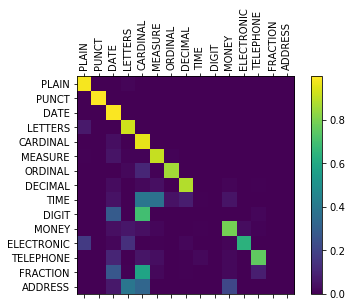

In [997]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    # category_i = categories_all.index(category)
    category_i = categories_index[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Predicting

In [774]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    #topv, topi = output.data.topk(n_predictions, 1, True)
    topv, topi = output.data.topk(n_predictions, 2, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][0][i]
        category_index = topi[0][0][i]
        print('(%.2f) %s' % (value, categories_all[category_index]))
        predictions.append([value, categories_all[category_index]])

In [981]:
predict('Normal')
predict('2017-12-12')
predict('~')
predict('20')


> Normal


TypeError: torch.addmm received an invalid combination of arguments - got (int, torch.cuda.FloatTensor, int, torch.FloatTensor, torch.cuda.FloatTensor, out=torch.cuda.FloatTensor), but expected one of:
 * (torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
